In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os, os.path, pickle, sys

from scipy import stats

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

from datetime import datetime

In [2]:
sys.path.append("/Users/hn/Documents/00_GitHub/Ag_Others/Ehsan/Wheat/")
import wheat_core as wc

In [3]:
data_dir_base = "/Users/hn/Documents/01_research_data/Ehsan/wheat/"
wheat_reOrganized = data_dir_base + "wheat_reOrganized/"

wheat_plot_dir = data_dir_base + "plots/"
dgdd_plot_dir  = data_dir_base + "plots/dGDD_precip/"
gdd_plot_dir   = data_dir_base + "plots/GDD_precip/"

os.makedirs(wheat_plot_dir, exist_ok=True)
os.makedirs(dgdd_plot_dir, exist_ok=True)
os.makedirs(gdd_plot_dir, exist_ok=True)

In [4]:
dpi_ = 200

In [5]:
data_ = pd.read_pickle(wheat_reOrganized + "average_and_seperate_varieties.sav")
list(data_.keys())

['averaged_varieties_weekly',
 'separate_varieties_weekly',
 'separate_varieties_annual',
 'averaged_varieties_annual',
 'separate_varieties_4season',
 'averaged_varieties_4season',
 'dates',
 'source_code',
 'Author',
 'Date']

In [6]:
averaged_varieties_weekly = data_["averaged_varieties_weekly"]
separate_varieties_weekly = data_["separate_varieties_weekly"]

separate_varieties_annual = data_["separate_varieties_annual"]
averaged_varieties_annual = data_["averaged_varieties_annual"]

separate_varieties_4season = data_["separate_varieties_4season"]
averaged_varieties_4season = data_["averaged_varieties_4season"]

dates = data_["dates"]

averaged_varieties_weekly.head(2)

location  year  yield    1_tavg     2_tavg     3_tavg     4_tavg     5_tavg  \
0   Almira  2005  42.09  7.725714  14.655000  11.125714  14.511429  14.647143   
1   Almira  2006  71.02  8.555714  12.201429   9.725000  12.675714  21.397857   

      6_tavg     7_tavg  ...     16_vs     17_vs  18_vs  19_vs  20_vs  21_vs  \
0  12.345000  18.738571  ...  3.300000  2.528571   2.55    NaN    NaN    NaN   
1  12.253571  16.030714  ...  2.457143  3.633333    NaN    NaN    NaN    NaN   

   22_vs  23_vs  24_vs  25_vs  
0    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN  

[2 rows x 303 columns]

In [7]:
averaged_varieties_weekly.head(2)

location  year  yield    1_tavg     2_tavg     3_tavg     4_tavg     5_tavg  \
0   Almira  2005  42.09  7.725714  14.655000  11.125714  14.511429  14.647143   
1   Almira  2006  71.02  8.555714  12.201429   9.725000  12.675714  21.397857   

      6_tavg     7_tavg  ...     16_vs     17_vs  18_vs  19_vs  20_vs  21_vs  \
0  12.345000  18.738571  ...  3.300000  2.528571   2.55    NaN    NaN    NaN   
1  12.253571  16.030714  ...  2.457143  3.633333    NaN    NaN    NaN    NaN   

   22_vs  23_vs  24_vs  25_vs  
0    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN  

[2 rows x 303 columns]

# GDD and Precip model

replace NAs in gdd and precip. since after harvest date, they are not measured, but those columns exist because of other location, year combos!

In [8]:
separate_varieties_4season[(separate_varieties_4season["location"] == "Almira") & 
                           (separate_varieties_4season["variety"] == "Alpowa")]

location  year variety  yield  s1_dgdd  s2_dgdd  s3_dgdd  s4_dgdd   s1_gdd  \
0    Almira  2005  Alpowa  43.90   58.710   50.540   69.335   82.000  336.125   
6    Almira  2006  Alpowa  69.97   92.315   65.005   55.890   58.670  302.105   
13   Almira  2007  Alpowa  37.97   73.965   61.250   63.395   58.555  350.365   
21   Almira  2008  Alpowa  53.17   83.665   57.080   63.145   66.940  335.240   
30   Almira  2009  Alpowa  57.23   60.725   57.875   58.550   53.800  282.850   
39   Almira  2010  Alpowa  52.07   59.725   46.025   50.075   31.610  332.305   
48   Almira  2011  Alpowa  56.13   77.990   79.115   82.085   48.310  346.370   
57   Almira  2012  Alpowa  45.30   92.330   62.695   75.255   47.980  416.240   
67   Almira  2013  Alpowa  61.43   86.030   65.535   63.390   40.635  447.190   
78   Almira  2014  Alpowa  21.63   68.175   50.900   46.830   61.775  386.235   

     s2_gdd   s3_gdd   s4_gdd  s1_precip  s2_precip  s3_precip  s4_precip  
0   418.830  514.615  912.340       51.0       28.3       11.4       11.4  
6   465.350  570.600  676.005        6.7       59.0       10.8        3.0  
13  438.165  551.350  755.525        9.4       21.6        4.2        8.2  
21  404.755  585.780  648.030        4.3       15.4        2.3        0.0  
30  501.150  530.030  711.260       21.6        6.3        2.5       15.9  
39  463.740  662.290  641.610       14.8       85.3        9.8        2.9  
48  518.630  681.320  572.580       67.8       19.8        6.4        0.0  
57  528.245  801.195  510.430       23.5       64.0       22.2        0.0  
67  507.205  791.245  717.160        9.6       48.0        5.0       19.3  
78  449.195  643.225  878.585        8.2       11.9       12.9       37.8

In [9]:
locations = separate_varieties_4season.location.unique()
varieties = separate_varieties_4season.variety.unique()

cols_= ["location", "wheat", "start_year", "end_year"]
years_loc_timeSpan = pd.DataFrame(columns = cols_, index = range(len(locations)*len(varieties)))
counter = 0

for a_loc in locations:
    for wheat in varieties:
        A = separate_varieties_4season[(separate_varieties_4season["location"] == a_loc) & (separate_varieties_4season["variety"] == wheat)].copy()
        years_loc_timeSpan.loc[counter, cols_] = [a_loc, wheat, A.year.min(), A.year.max()]
        counter+=1

In [10]:
tick_legend_FontSize = 15
params = {"legend.fontsize": tick_legend_FontSize,
          "legend.title_fontsize" : tick_legend_FontSize * 1.3,
          "legend.markerscale" : 2,
          # 'figure.figsize': (6, 4),
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}
plt.rcParams.update(params)

In [11]:
season_gdd_cols = [x for x in separate_varieties_4season.columns if "gdd" in x]
season_gdd_cols = [x for x in season_gdd_cols if not("dgdd" in x)]

season_dgdd_cols = [x for x in separate_varieties_4season.columns if "dgdd" in x]
season_precip_cols = [x for x in separate_varieties_4season.columns if "precip" in x]

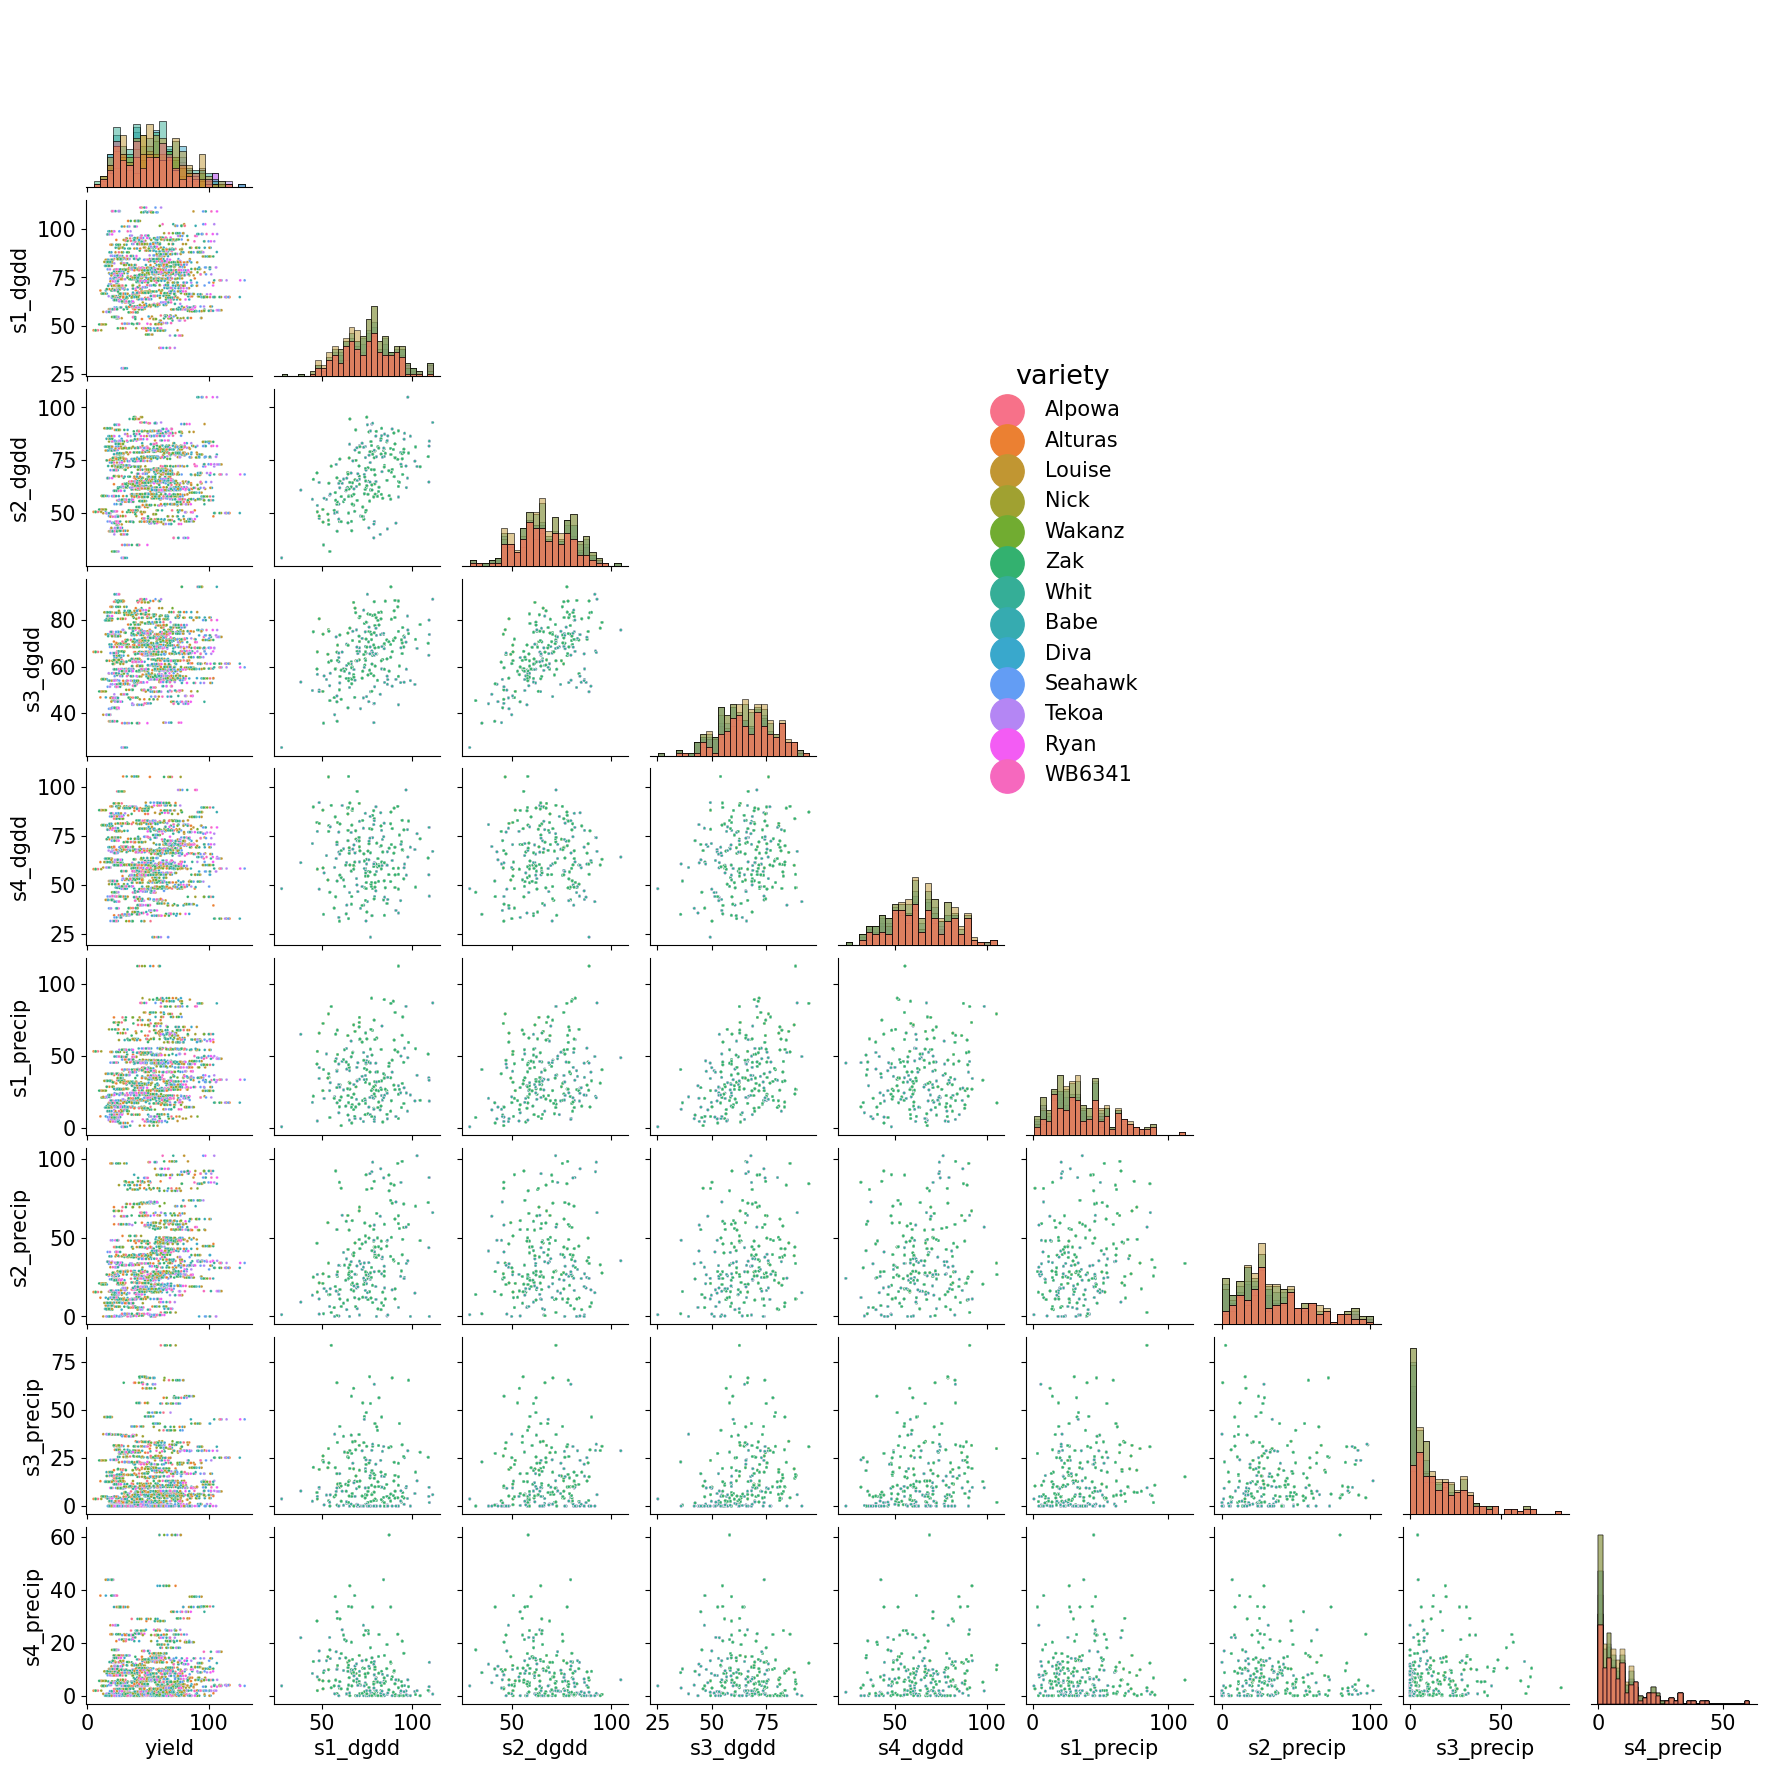

In [12]:
cols_ = ["yield"] + season_dgdd_cols + season_precip_cols

scatt_ = sns.pairplot(separate_varieties_4season[cols_+["variety"]], 
                      hue="variety", diag_kind="hist", 
                      size=2, corner=True, plot_kws={"s": 4})

sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.5, .8))

fig_name = dgdd_plot_dir + "4Season_corr"
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")

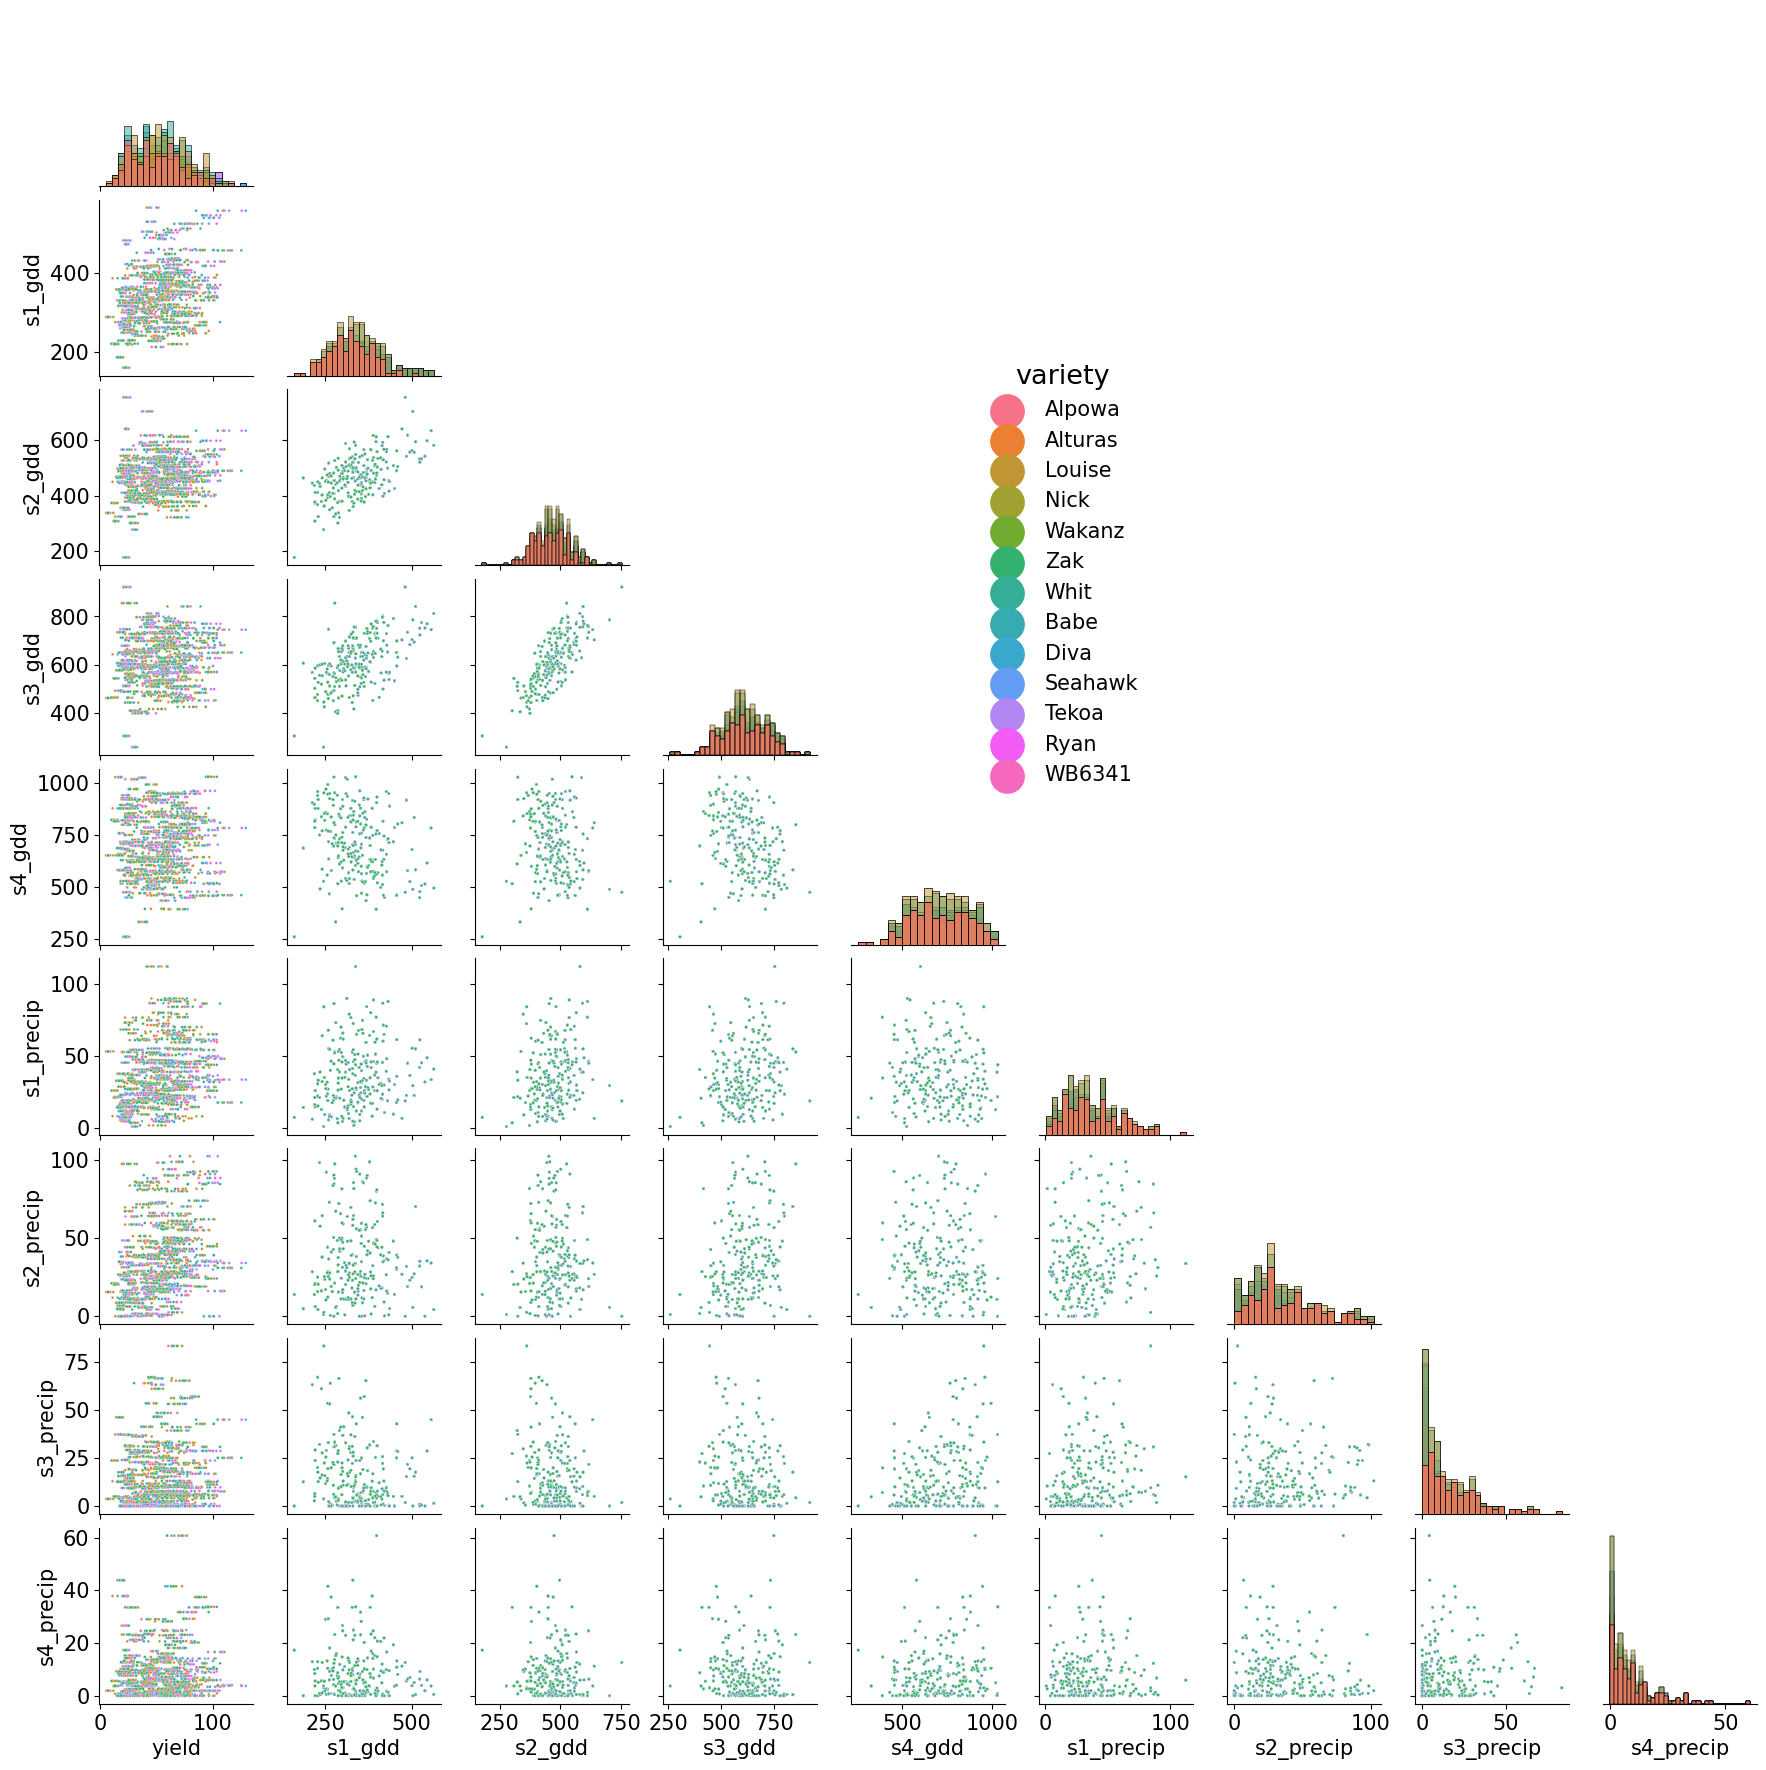

In [13]:
cols_ = ["yield"] + season_gdd_cols + season_precip_cols

scatt_ = sns.pairplot(separate_varieties_4season[cols_+["variety"]], 
                      hue="variety", diag_kind="hist", 
                      size=2, corner=True, plot_kws={"s": 4})

sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.5, .8))

fig_name = gdd_plot_dir + "4Season_corr"
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")

In [14]:
separate_varieties_4season.head(2)

location  year  variety  yield  s1_dgdd  s2_dgdd  s3_dgdd  s4_dgdd   s1_gdd  \
0   Almira  2005   Alpowa   43.9    58.71    50.54   69.335     82.0  336.125   
1   Almira  2005  Alturas   37.7    58.71    50.54   69.335     82.0  336.125   

   s2_gdd   s3_gdd  s4_gdd  s1_precip  s2_precip  s3_precip  s4_precip  
0  418.83  514.615  912.34       51.0       28.3       11.4       11.4  
1  418.83  514.615  912.34       51.0       28.3       11.4       11.4

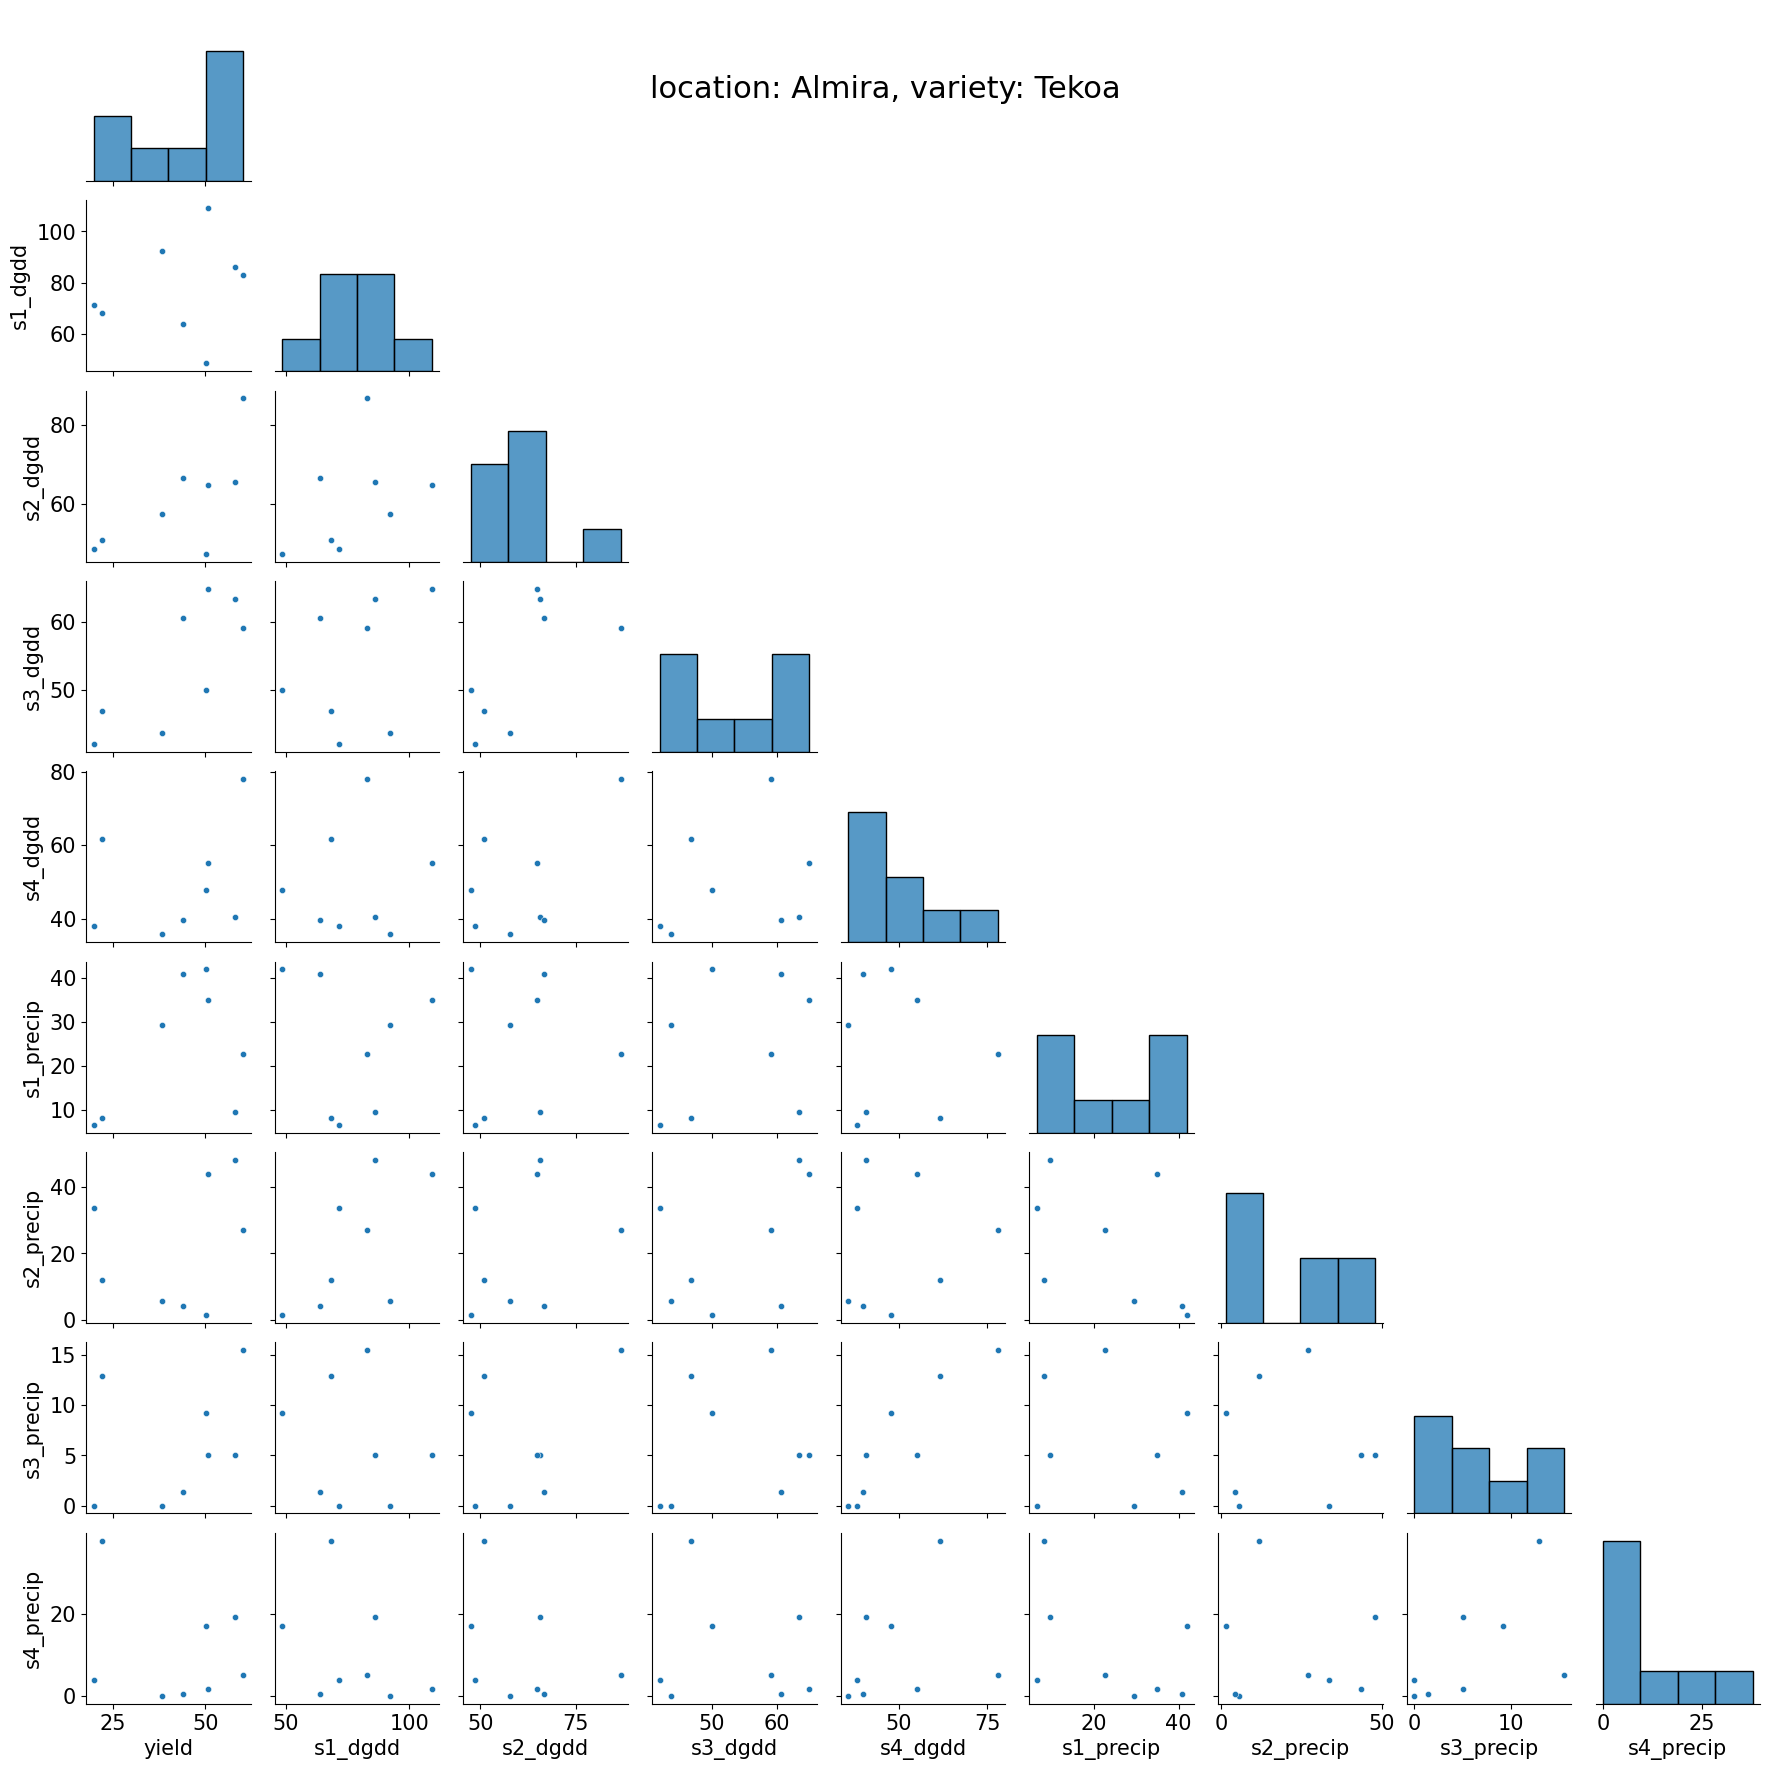

In [15]:
cols_ = ["yield"] + season_dgdd_cols + season_precip_cols

loc_ = locations[0]
variety = varieties[10]
df_vari = separate_varieties_4season[(separate_varieties_4season["variety"] == variety) & 
                                     (separate_varieties_4season["location"] == loc_)]

scatt_ = sns.pairplot(df_vari[cols_], size=2, corner=True, plot_kws={"s": 20})

title_ = "location: {}, variety: {}".format(loc_, variety)
scatt_.fig.suptitle(title_, y=.95, fontsize=22)

fig_name = dgdd_plot_dir + "4Season_" + variety + "_"  + loc_ + "_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")
del(loc_, variety)

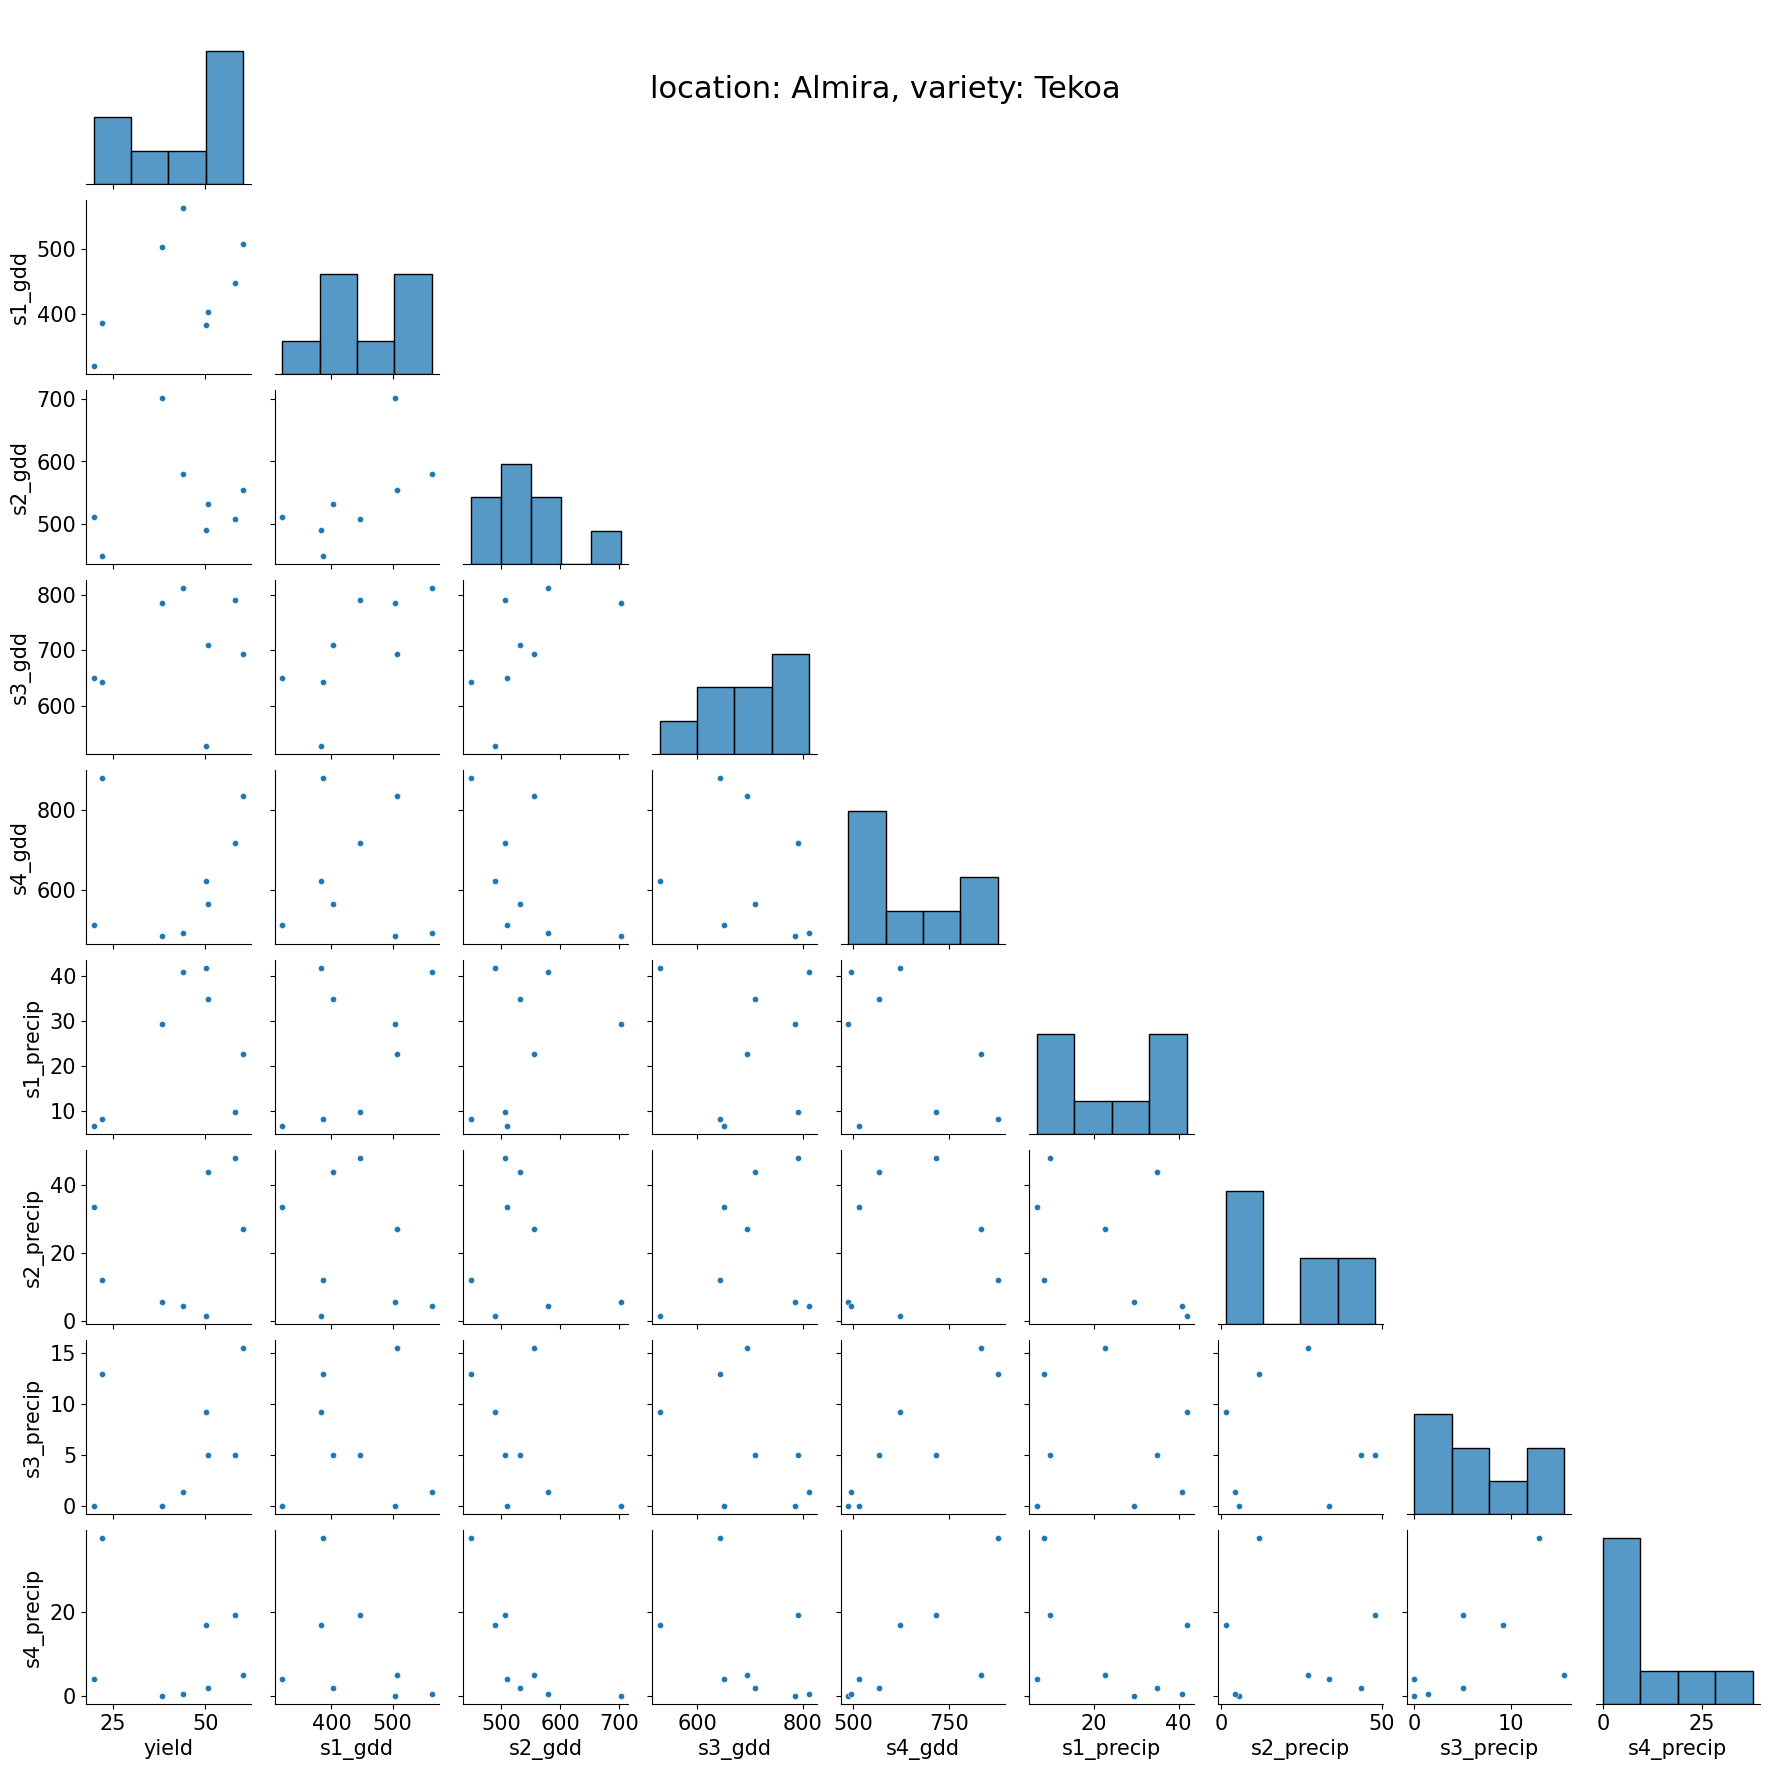

In [16]:
cols_ = ["yield"] + season_gdd_cols + season_precip_cols

loc_, variety = locations[0], varieties[10]
df_vari = separate_varieties_4season[(separate_varieties_4season["variety"] == variety) & 
                                     (separate_varieties_4season["location"] == loc_)]

scatt_ = sns.pairplot(df_vari[cols_], size=2, corner=True, plot_kws={"s": 20})
title_ = "location: {}, variety: {}".format(loc_, variety)
scatt_.fig.suptitle(title_, y=.95, fontsize=22)

fig_name = gdd_plot_dir + "4Season_" + variety + "_"  + loc_ + "_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")

del(loc_, variety)

### for a given variety

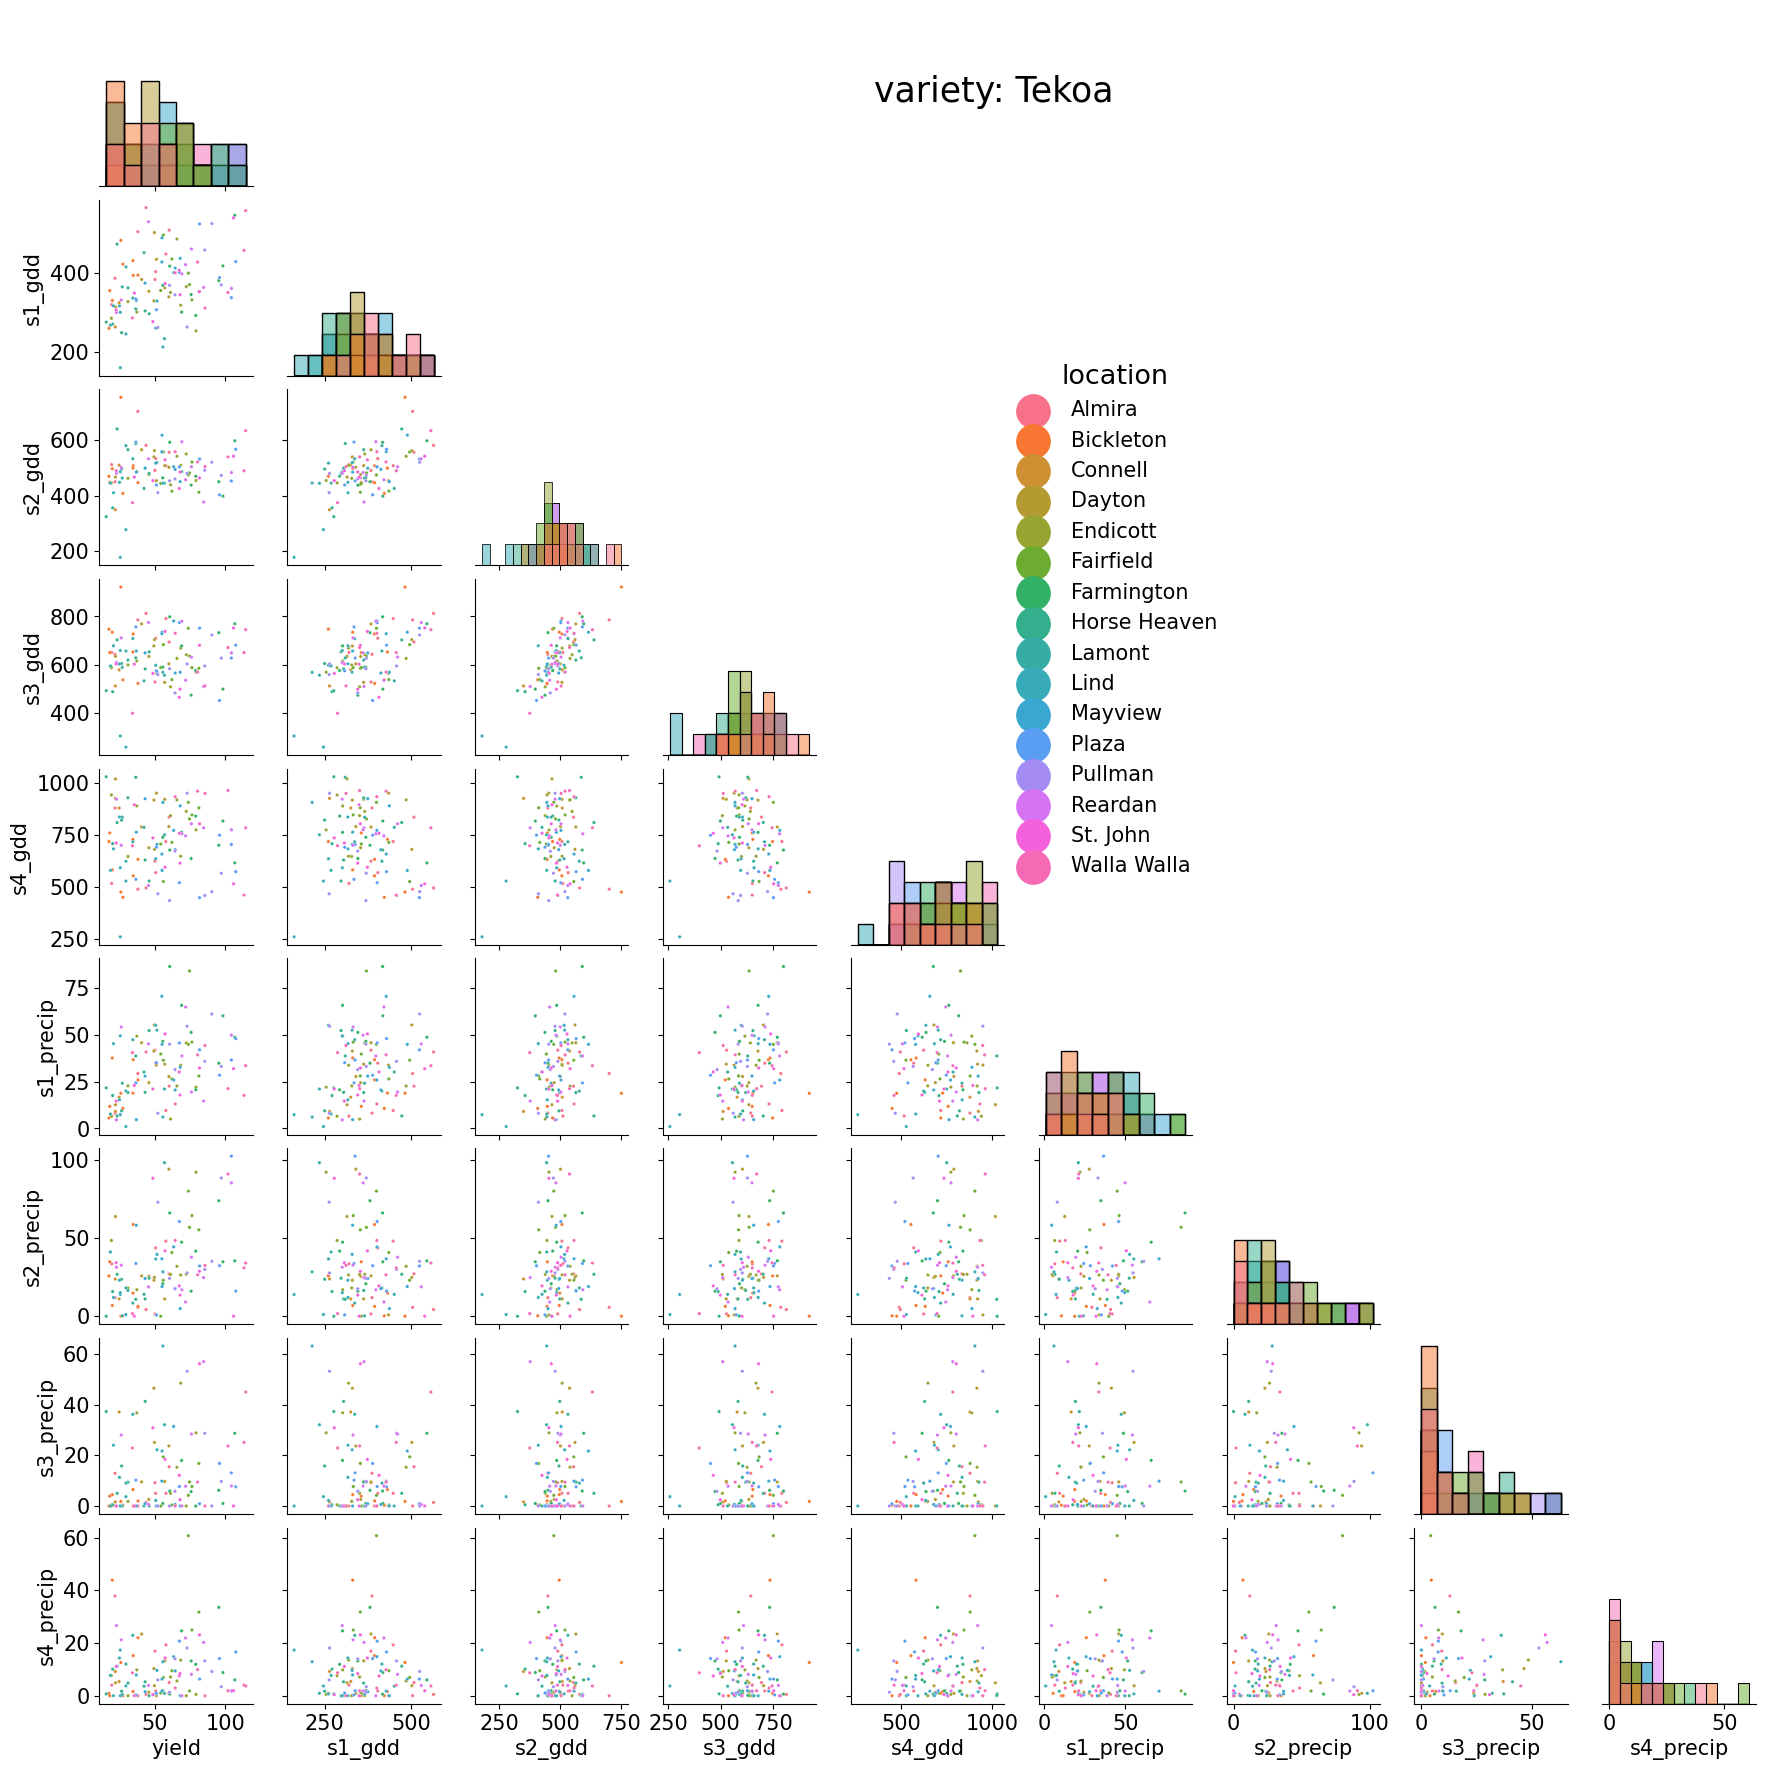

In [17]:
variety = varieties[10]
df_vari = separate_varieties_4season[(separate_varieties_4season["variety"] == variety)]
scatt_ = sns.pairplot(df_vari[cols_ + ["location"]], 
                      hue="location", diag_kind="hist", size=2, corner=True, plot_kws={"s": 6})

sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.5, .8))
title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.95, fontsize=25)

file_post = "4Season_" + variety + "_corr"
fig_name = dgdd_plot_dir + file_post
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")
del(variety, df_vari)

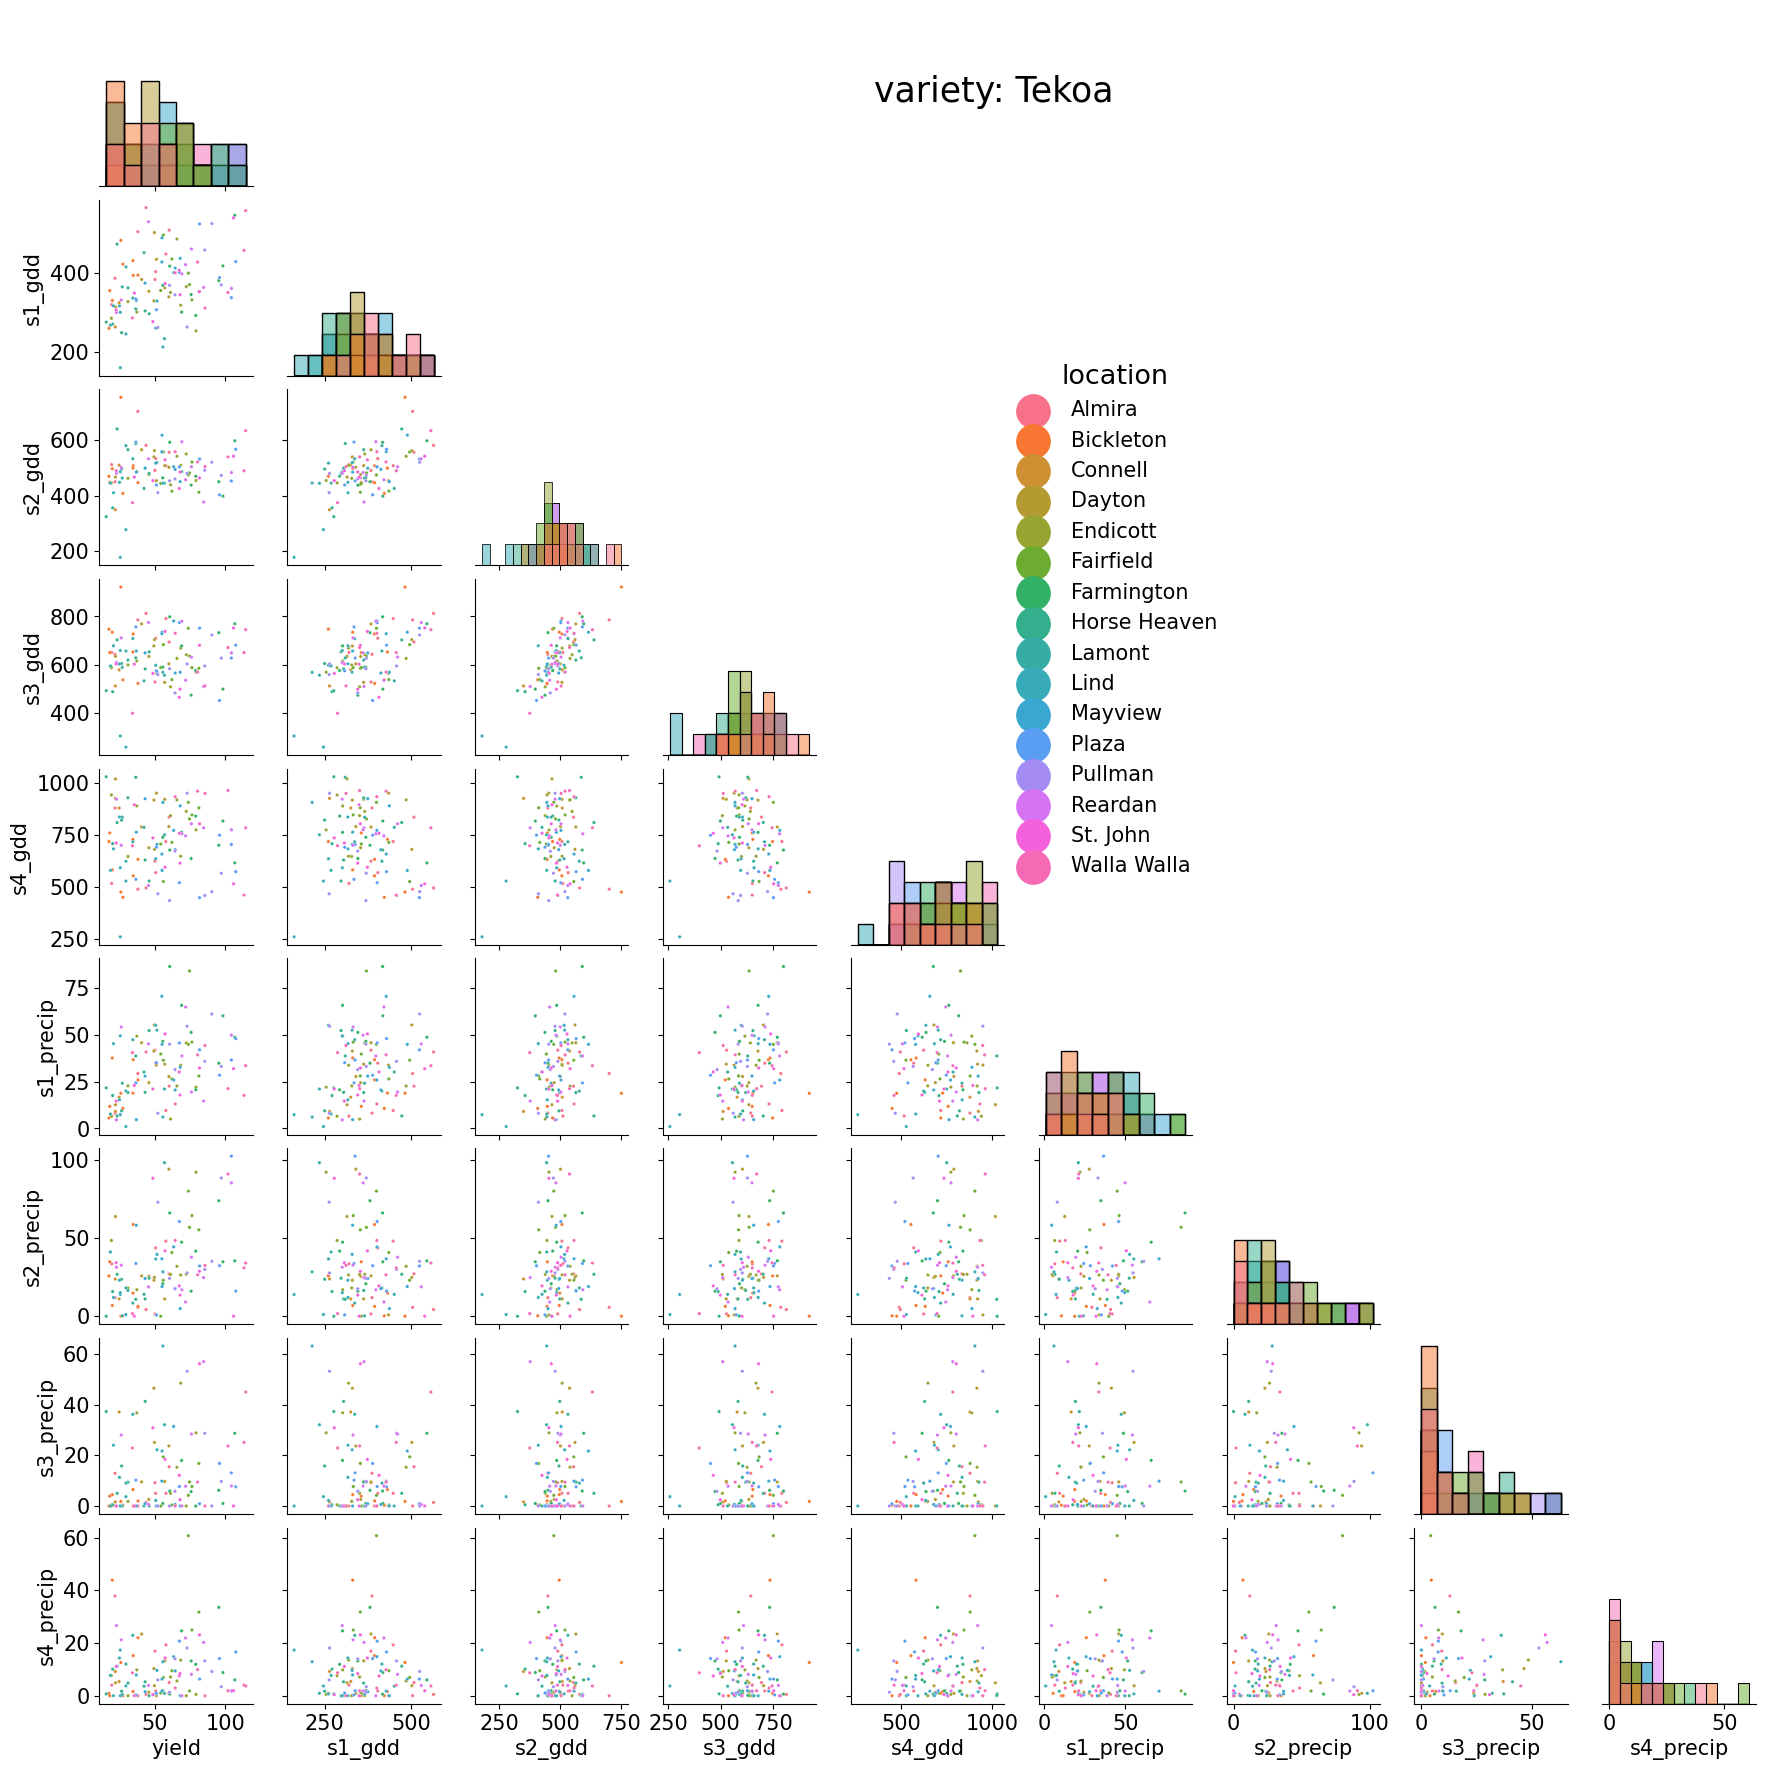

In [18]:
variety = varieties[10]
df_vari = separate_varieties_4season[(separate_varieties_4season["variety"] == variety)]

scatt_ = sns.pairplot(df_vari[cols_ + ["location"]], hue="location", 
                      diag_kind="hist", size=2, corner=True, plot_kws={"s": 6})

sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.5, .8))
title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.95, fontsize=25)

fig_name = gdd_plot_dir + "4Season_" + variety + "_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")

del(variety)

### Not any correlation between yield and seasonal variables. What about annual?

May be correlations occur in higher dimension (i.e. not pairwise vars)?

In [19]:
separate_varieties_annual.head(2)

location  year  variety  yield  year_gdd  year_dgdd  year_precip
0   Almira  2005   Alpowa   43.9   2181.91    260.585        102.1
1   Almira  2005  Alturas   37.7   2181.91    260.585        102.1

In [20]:
tick_legend_FontSize = 10
params = {"legend.fontsize": tick_legend_FontSize*0.8,
          "legend.title_fontsize" : tick_legend_FontSize * 1.3,
          "legend.markerscale" : 1.5,
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}
plt.rcParams.update(params)

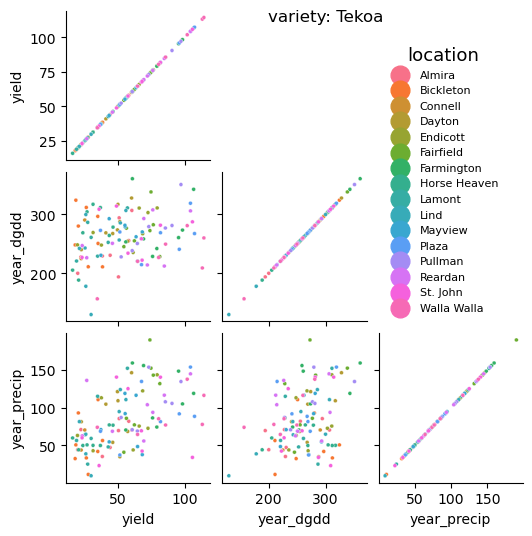

In [23]:
cols_ = ["yield", "year_dgdd", "year_precip"]+["location"]
variety = varieties[10]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety)]
scatt_ = sns.pairplot(df_vari[cols_], hue="location", diag_kind="hist", size=1.8, corner=True, plot_kws={"s": 8})

title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.98) 
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.58, .93))


fig_name = dgdd_plot_dir + "annual_" + variety + "_corr2.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")
del(variety)

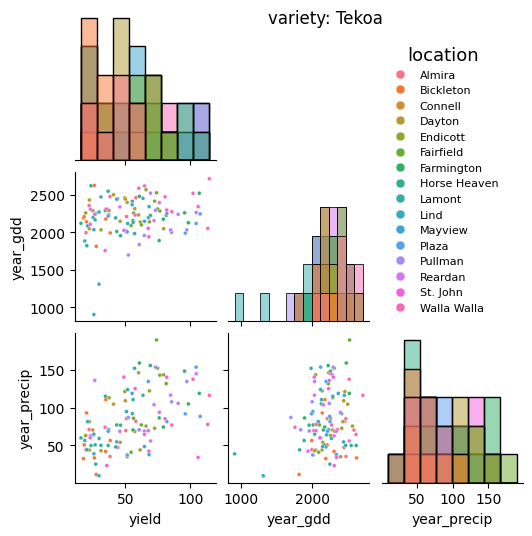

In [23]:
cols_ = ["yield", "year_gdd", "year_precip"]+["location"]
variety = varieties[10]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety)]
scatt_ = sns.pairplot(df_vari[cols_], hue="location", diag_kind="hist", size=1.8, corner=True, plot_kws={"s": 8})

title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.98) 
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.58, .93))

fig_name = gdd_plot_dir + "annual_" + variety + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

del(variety)

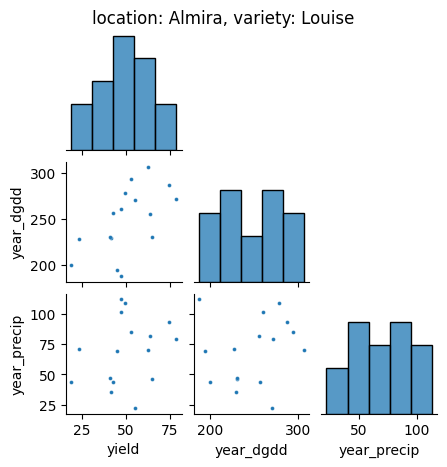

In [24]:
cols_ = ["yield", "year_dgdd", "year_precip"]

loc_, variety = locations[0], varieties[2]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety) & 
                                    (separate_varieties_annual["location"] == loc_)]

scatt_ = sns.pairplot(df_vari[cols_], size=1.5, corner=True, plot_kws={"s": 8})

title_ = "location: {}, variety: {}".format(loc_, variety)
scatt_.fig.suptitle(title_, y=1.02, fontsize=12)

fig_name = dgdd_plot_dir + "annual_" + variety + "_" + loc_ + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")
del(loc_, variety)

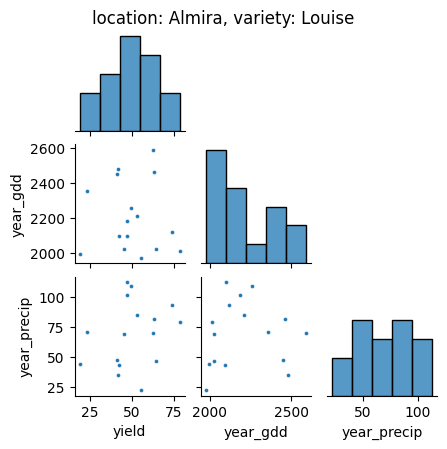

In [25]:
cols_ = ["yield", "year_gdd", "year_precip"]
loc_ = locations[0]
variety = varieties[2]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety) & 
                                    (separate_varieties_annual["location"] == loc_)]
scatt_ = sns.pairplot(df_vari[cols_], size=1.5, corner=True, plot_kws={"s": 8})
title_ = "location: {}, variety: {}".format(loc_, variety)
scatt_.fig.suptitle(title_, y=.98) 

fig_name = gdd_plot_dir + "annual_" + variety + "_" + loc_ + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

del(variety, loc_)

In [26]:
tick_legend_FontSize = 10
params = {"legend.fontsize": tick_legend_FontSize*0.8,
          "legend.title_fontsize" : tick_legend_FontSize * 1.3,
          "legend.markerscale" : 1.5,
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}

plt.rcParams.update(params)

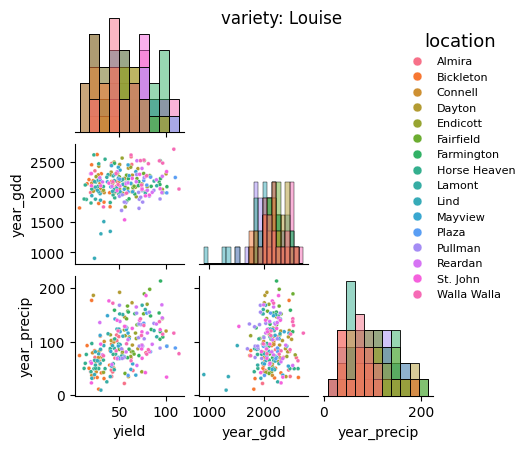

In [27]:
cols_ = ["yield", "year_gdd", "year_precip"] + ["location"]

variety = varieties[2]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety)]
scatt_ = sns.pairplot(df_vari[cols_], hue="location", diag_kind="hist", size=1.5, corner=True, plot_kws={"s": 8})

title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.98) 
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.7, .95))

fig_name = gdd_plot_dir + "annual_" + variety + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")
del(variety)

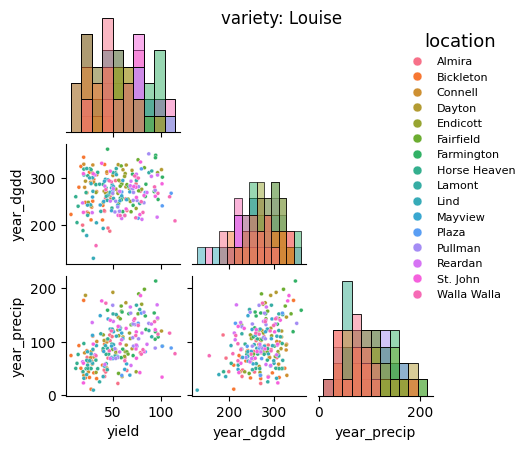

In [28]:
cols_ = ["yield", "year_dgdd", "year_precip"]+["location"]

variety = varieties[2]
df_vari = separate_varieties_annual[(separate_varieties_annual["variety"] == variety)]
scatt_ = sns.pairplot(df_vari[cols_], hue="location", diag_kind="hist", size=1.5, corner=True, plot_kws={"s": 8})

title_ = "variety: {}".format(variety)
scatt_.fig.suptitle(title_, y=.98) 
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.7, .95))

fig_name = dgdd_plot_dir + "annual_" + variety + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")
del(variety)

### Take average of yield per location, year!
and see if that solves the problem of wide range of yields

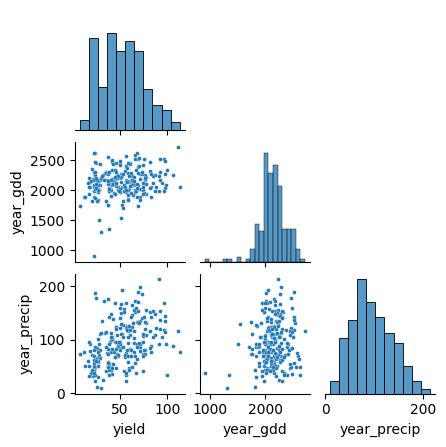

In [29]:
cols_ = ["yield", "year_gdd", "year_precip"]         
scatt_ = sns.pairplot(averaged_varieties_annual[cols_], size=1.5, corner=True, plot_kws={"s": 8})
fig_name = dgdd_plot_dir + "AvgYield_annual_corr.pdf"
# plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

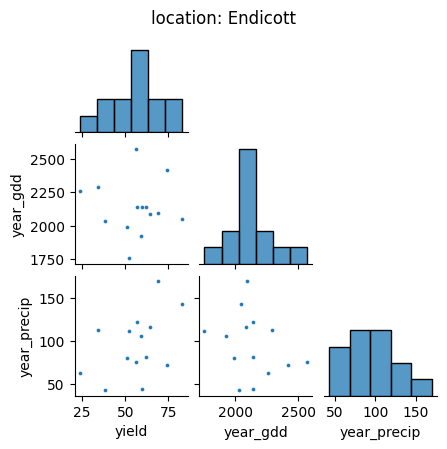

In [30]:
cols_ = ["yield", "year_gdd", "year_precip"]         
loc_ = locations[4]
df_vari = averaged_varieties_annual[(averaged_varieties_annual["location"] == loc_)]
scatt_ = sns.pairplot(df_vari[cols_ ], size=1.5, corner=True, plot_kws={"s": 8})

title_ = "location: {}".format(loc_)
scatt_.fig.suptitle(title_, y=.98) 

fig_name = gdd_plot_dir + "AvgYield_annual_" + loc_ + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")
del(loc_)

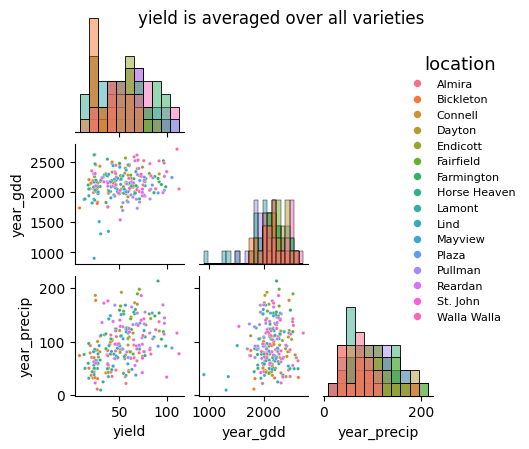

In [31]:
cols_ = ["yield", "year_gdd", "year_precip"] + ["location"]

scatt_ = sns.pairplot(averaged_varieties_annual[cols_], 
                      hue="location", diag_kind="hist",
                      size=1.5, corner=True, plot_kws={"s": 6})

title_ = "yield is averaged over all varieties"
scatt_.fig.suptitle(title_, x=0.5, y=.98, fontsize=12)
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.7, .9))

fig_name = gdd_plot_dir + "annual_yieldAvg_corr"
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")

In [36]:
sorted(averaged_varieties_annual["location"].unique())

['Almira',
 'Bickleton',
 'Connell',
 'Dayton',
 'Endicott',
 'Fairfield',
 'Farmington',
 'Horse Heaven',
 'Lamont',
 'Lind',
 'Mayview',
 'Plaza',
 'Pullman',
 'Reardan',
 'St. John',
 'Walla Walla']

'Endicott'

## Seasonal Average

In [32]:
tick_legend_FontSize = 15
params = {"legend.fontsize": tick_legend_FontSize,
          "legend.title_fontsize" : tick_legend_FontSize * 1.3,
          "legend.markerscale" : 2,
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}
plt.rcParams.update(params)

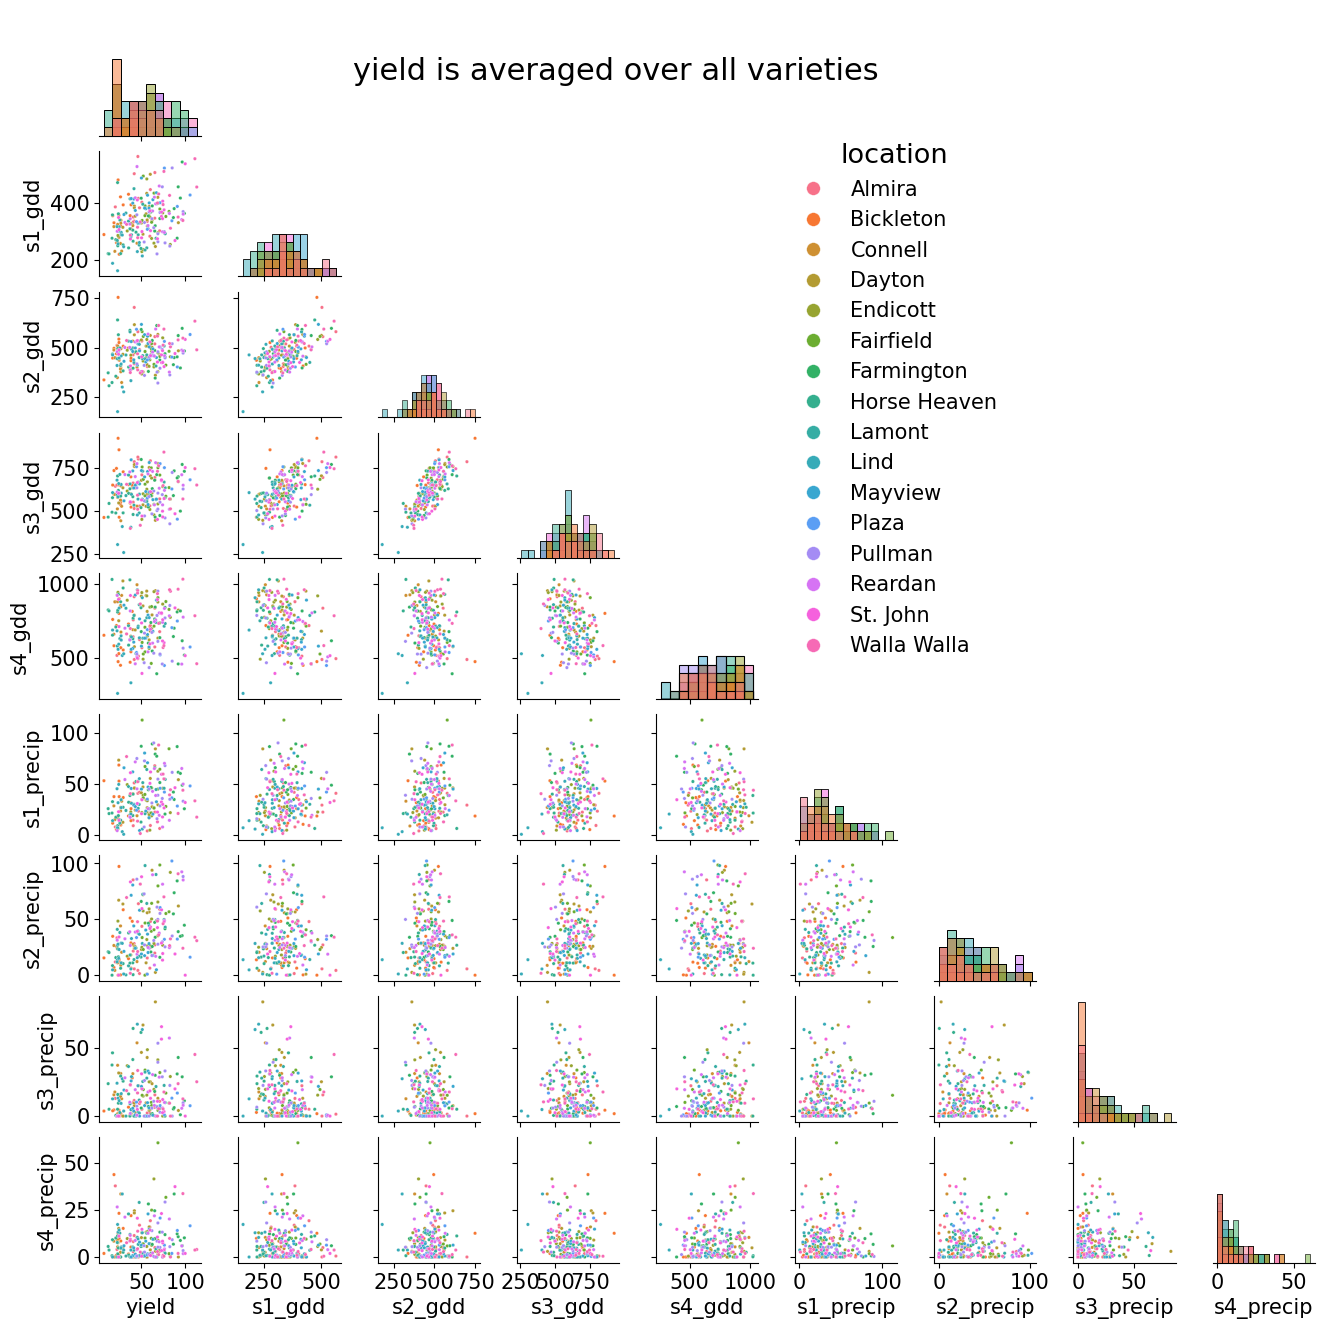

In [33]:
cols_ = ["yield"] +  season_gdd_cols + season_precip_cols + ["location"]

loc_ = locations[0]
# df_vari = averaged_varieties_4season[(averaged_varieties_4season["location"] == loc_)]
scatt_ = sns.pairplot(averaged_varieties_4season[cols_], 
                      hue="location", diag_kind="hist",
                      size=1.5, corner=True, plot_kws={"s": 6})

title_ = "yield is averaged over all varieties"
scatt_.fig.suptitle(title_, x=0.4, y=.95, fontsize=22)
sns.move_legend(scatt_, "upper left", bbox_to_anchor=(0.5, .9))

fig_name = gdd_plot_dir + "4Season_averaged_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")